In [1]:
!pip install face_recognition
!pip install ffmpeg
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 25 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=7fec9edf5c1d8b89d3a9ff90de8ab9c767304a1ca19da6526b662b285e49cc74
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=ead3db8661390dc49c75fad4ae594f0332bf3263585e0f78248f1171b42f2263
  Stored in directory: /root/.cache/pip/wheels/64/80/6e/caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
Successfully built ffmpeg
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Para a IA funcionar no colab corretamente é necessário uma GPU! Isto irá confirmar que uma GPU está ativa!
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18107534782495735541
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2338598588350712333
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
import face_recognition
from moviepy.editor import *
import moviepy.editor
import ffmpeg
import glob
import cv2
import numpy as np
import os
import shutil
from tqdm.notebook import tqdm

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3956736/45929032 bytes (8.6%)8077312/45929032 bytes (17.6%)12181504/45929032 bytes (26.5%)16048128/45929032 bytes (34.9%)19939328/45929032 bytes (43.4%)23805952/45929032 bytes (51.8%)27942912/45929032 bytes (60.8%)31916032/45929032 bytes (69.5%)35971072/45929032 bytes (78.3%)40009728/45929032 bytes (87.1%)44113920/45929032 bytes (96.0%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [4]:
def censura_rosto(filename, top, right, bottom, left):
  
  #Lendo e borrando toda a imagem usando Convolussão Gaussiana - Blur
  image = cv2.imread(filename)
  blurred_image = cv2.GaussianBlur(image,(153, 153), 0)

  #Criando uma mask para delimitar a área borrada
  roi_corners = np.array([[(left,top),(right,top),(right,bottom),(left,bottom)]],dtype = np.int32)
  mask = np.zeros(image.shape, dtype=np.uint8)
  channel_count = image.shape[2]
  ignore_mask_color = (255,)*channel_count
  cv2.fillPoly(mask, roi_corners, ignore_mask_color)
  mask_inverse = np.ones(mask.shape).astype(np.uint8)*255 - mask

  #Juntando a mask e a imagem borrada
  final_image = cv2.bitwise_and(blurred_image, mask) + cv2.bitwise_and(image, mask_inverse)
  cv2.imwrite(filename,final_image)
  

In [5]:
def censura_foto(filename, number_of_times_to_upsample = 2):

  image = face_recognition.load_image_file(filename)
  face_locations = face_recognition.face_locations(image, number_of_times_to_upsample)
  for (top, right, bottom, left) in face_locations: 
    censura_rosto(filename, top, right, bottom, left)
    

In [6]:
def extrai_video(filename):

  #criando pasta para os frames
  
  os.makedirs(os.path.join("./", "video"))

  #extraindo o audio
  clip = moviepy.editor.VideoFileClip(filename)
  clip.audio.write_audiofile("./video/" +"audio.mp3")

  #extraindo os frames
  vidcap = cv2.VideoCapture(filename)
  success,image = vidcap.read()
  count = 0 

  while success:
    cv2.imwrite("./video/" + "frame%s.png" % str(count).zfill(8), image)     
    success,image = vidcap.read()
    count += 1

  print("Frames extraidos!")
  vidcap.release()
  cv2.destroyAllWindows()


In [7]:
def censura_video(filename, number_of_times_to_upsample = 1):  
  #Atenção: Talvez seja possível fazer usando Batch para ser mais rápido na GPU, porém sempre falta memória!
  extrai_video(filename)

  files = glob.glob(f"/content/video/*.png")
  files.sort()

  for frames in tqdm(files, desc="Censurando os Frames... " ):
   censura_foto(frames, number_of_times_to_upsample)
  
  frame = cv2.imread(os.path.join("/content/video/", files[0]))
  height, width, layers = frame.shape
  video = cv2.VideoWriter("output.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30, (width,height))

  for frame in tqdm(files, desc="Criando o vídeo... "):
    video.write(cv2.imread(os.path.join("./", frame)))
  
  cv2.destroyAllWindows()
  video.release()

  #juntando o audio do vídeo
  print("Criando o Audio... ")
  input_video = ffmpeg.input('./output.mp4')
  input_audio = ffmpeg.input('./video/audio.mp3')
  ffmpeg.concat(input_video, input_audio, v=1, a=1).output('./finished_video.mp4').run()

  #Apagando a pasta "./video/" e o "output.mp4" para evitar mesclagem de frames
  shutil.rmtree(os.path.join("./", "video"))
  os.remove("./output.mp4")
  print("Concluido com Sucesso!")

Foto Original: 


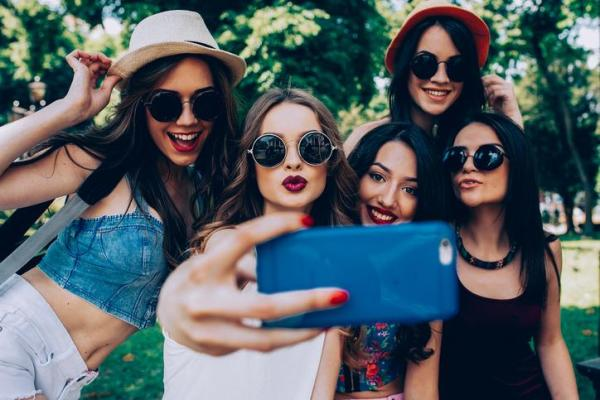

Resultado: 


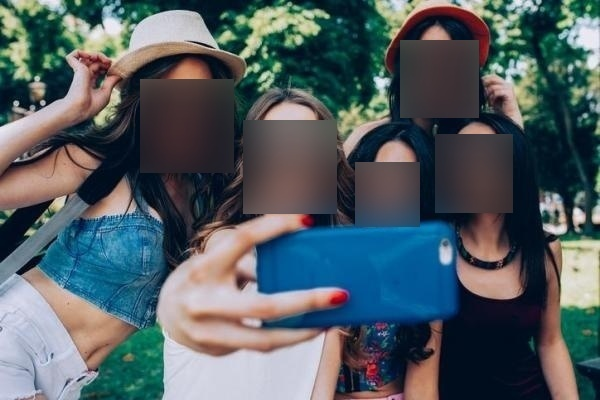

In [8]:
from google.colab.patches import cv2_imshow
original = cv2.imread("test.jpg")
print("Foto Original: ")
cv2_imshow(original)
censura_foto("test.jpg")
print("Resultado: ")
result = cv2.imread("test.jpg")
cv2_imshow(result)

In [9]:
censura_video("test.mp4", 1)

[MoviePy] Writing audio in ./video/audio.mp3


100%|██████████| 393/393 [00:00<00:00, 799.58it/s]

[MoviePy] Done.


Frames extraidos!


Censurando os Frames... :   0%|          | 0/426 [00:00<?, ?it/s]

Criando o vídeo... :   0%|          | 0/426 [00:00<?, ?it/s]

Criando o Audio... 
Concluido com Sucesso!
